In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMGAE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [11]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "Cotton",
    shuffle = True,
image_size = (IMGAE_SIZE,IMGAE_SIZE),
batch_size = BATCH_SIZE)


Found 2300 files belonging to 4 classes.


In [12]:
class_names=dataset.class_names
class_names

['diseased cotton leaf',
 'diseased cotton plant',
 'fresh cotton leaf',
 'fresh cotton plant']

In [13]:
##Show one image batch 
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 3 1 3 2 3 2 2 3 0 0 3 2 3 1 1 2 1 1 3 3 3 2 1 1 3 3 0 0 3 2]


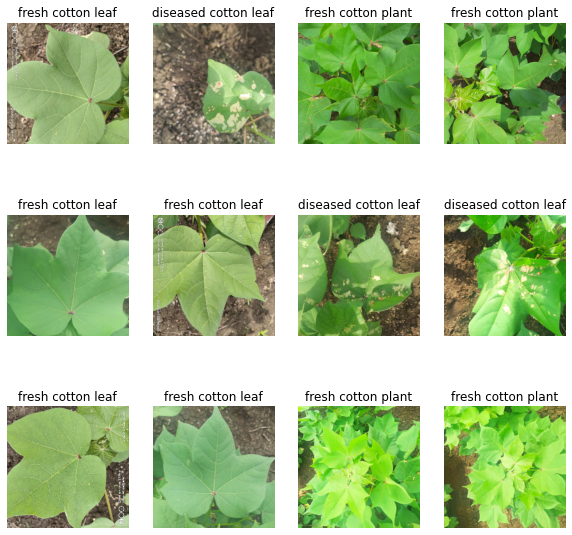

In [8]:
##Show image here
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [14]:
len(dataset)

72

In [15]:
##Splite data set to 80%=Training, 10% validation, 10% testing
## To know accurantely what 80% represents 
train_size=0.8
len(dataset)*train_size

57.6

In [16]:
dataset.take(57)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
##skipe 57 
test_dataset=dataset.skip(57)
len(test_dataset)

15

In [18]:
## To know accurantely what 10% represents  of validation dataset
validation_size=0.1
len(dataset)*validation_size

7.2

In [19]:
validation_dataset=test_dataset.take(7)
len(validation_dataset)

7

In [20]:
##skipe test=6 
test_dataset=test_dataset.skip(7)
len(test_dataset)

8

In [21]:
##Function for partitions
def get_dataset_partitions_tf(ds, train_split=0.8, validation_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)

    train_size= int(train_split*ds_size)
    validation_size= int(validation_split*ds_size)

    train_ds=ds.take(train_size)
    
    validation_ds=ds.skip(train_size).take(validation_size)
    test_ds=ds.skip(train_size).skip(validation_size)


    return  train_ds, validation_ds, test_ds

In [43]:
train_ds, validation_ds, test_ds= get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

57

In [33]:
len(validation_ds)

7

In [25]:
len(test_ds)

8

In [34]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds=  validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
##Creating layers for preprocessing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMGAE_SIZE,IMGAE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)])

In [47]:
Data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [50]:


##Building a model using convolutional neural network(CNN)

input_shape = (BATCH_SIZE, IMGAE_SIZE,IMGAE_SIZE, CHANNELS)
n_classes=4

model= models.Sequential([
    resize_and_rescale,
    Data_augmentation,
    layers.Conv2D(32,(4,4), activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (4,4), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (4,4), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (4,4), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (4,4), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (4,4), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),

])
model.build(input_shape=input_shape)


In [51]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_9 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_52 (Conv2D)          (32, 253, 253, 32)        1568      
                                                                 
 max_pooling2d_52 (MaxPoolin  (32, 126, 126, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (32, 123, 123, 64)        32832     
                                                                 
 max_pooling2d_53 (MaxPoolin  (32, 61, 61, 64)         0         
 g2D)                                                

In [52]:
model.compile(
optimizer='adam',
 loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

In [53]:
##Mode fit
history= model.fit(
       train_ds,
        epochs=EPOCHS,
         batch_size=BATCH_SIZE,
         verbose=1,
          validation_data=validation_ds
)

Epoch 1/50
57/57 [==============================] - 123s 2s/step - loss: 1.3356 - accuracy: 0.4046 - val_loss: 1.3945 - val_accuracy: 0.3839
Epoch 2/50
57/57 [==============================] - 141s 2s/step - loss: 1.2000 - accuracy: 0.4484 - val_loss: 1.0931 - val_accuracy: 0.4598
Epoch 3/50
57/57 [==============================] - 182s 3s/step - loss: 1.0584 - accuracy: 0.5516 - val_loss: 0.9348 - val_accuracy: 0.6339
Epoch 4/50
57/57 [==============================] - 132s 2s/step - loss: 0.9550 - accuracy: 0.6060 - val_loss: 0.8717 - val_accuracy: 0.6607
Epoch 5/50
57/57 [==============================] - 178s 3s/step - loss: 0.8745 - accuracy: 0.6456 - val_loss: 0.8113 - val_accuracy: 0.6920
Epoch 6/50
57/57 [==============================] - 146s 3s/step - loss: 0.7355 - accuracy: 0.7016 - val_loss: 0.7103 - val_accuracy: 0.6741
Epoch 7/50
57/57 [==============================] - 150s 2s/step - loss: 0.6438 - accuracy: 0.7379 - val_loss: 0.5468 - val_accuracy: 0.7500
Epoch 8/50
57

In [54]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 11s 598ms/step - loss: 0.1309 - accuracy: 0.9531


In [55]:
acc= history.history['accuracy']
validation_acc=history.history['val_accuracy']

loss= history.history['loss']
validation_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and validation Accuracy')

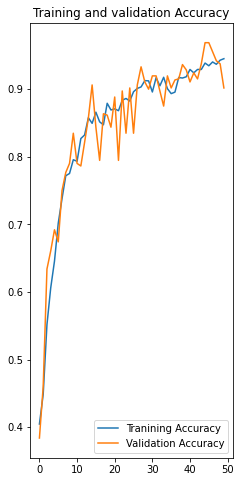

In [56]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Tranining Accuracy')
plt.plot(range(EPOCHS), validation_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation Accuracy')

first image to predict
first image actual label: fresh cotton plant
1/1 [==============================] - 1s 1s/step
fresh cotton plant


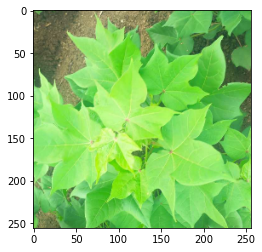

In [57]:
for images_batch, labels_batch in test_ds.take(1):

    first_image=images_batch[0].numpy().astype('uint8')
    first_label= labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("first image actual label:",class_names[ first_label])
    
    batch_prediction= model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [58]:
## Predication model take img+ model

def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array= tf.expand_dims(img_array,0)

    prediction= model.predict(img_array)
    
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 *(np.max(prediction[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 89ms/step


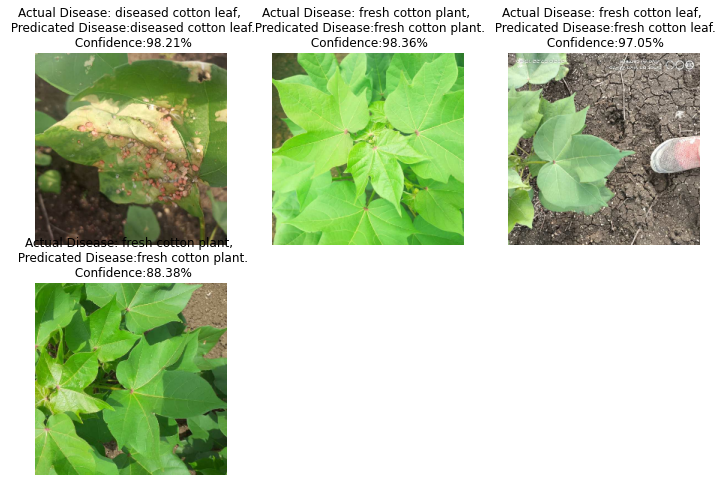

In [59]:
## Predication for the dataset
plt.figure(figsize=(12,12))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax= plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicated_class, confidence= predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual Disease: {actual_class}, \n Predicated Disease:{predicated_class}.\n Confidence:{confidence}%")
        plt.axis("off")

In [61]:
##Versioning the models
import os
model_version=max([int(i) for i in os.listdir("../Cotton_Model")+[0]])+1
model.save(f"../Cotton_Model/{model_version}")


INFO:tensorflow:Assets written to: ../Cotton_Model/1\assets


INFO:tensorflow:Assets written to: ../Cotton_Model/1\assets


In [62]:
model.save("../Cotton_Model.h5")